Using device: cuda
Original dataset label counts:
Label 5: 5421 samples
Label 0: 5923 samples
Label 4: 5842 samples
Label 1: 6742 samples
Label 9: 5949 samples
Label 2: 5958 samples
Label 3: 6131 samples
Label 6: 5918 samples
Label 7: 6265 samples
Label 8: 5851 samples
Client 0 label counts:
[593, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Client 1 label counts:
[593, 750, 0, 0, 0, 0, 0, 0, 0, 0]
Client 2 label counts:
[593, 750, 745, 0, 0, 0, 0, 0, 0, 0]
Client 3 label counts:
[593, 750, 745, 876, 0, 0, 0, 0, 0, 0]
Client 4 label counts:
[593, 750, 745, 876, 974, 0, 0, 0, 0, 0]
Client 5 label counts:
[593, 750, 745, 876, 974, 1085, 0, 0, 0, 0]
Client 6 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 0, 0, 0]
Client 7 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 2089, 0, 0]
Client 8 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 2089, 2926, 0]
Client 9 label counts:
[586, 742, 743, 875, 972, 1081, 1478, 2087, 2925, 5949]
with ewc
with ewc
with ewc
with ewc
with ewc
with ewc
with ewc
wi

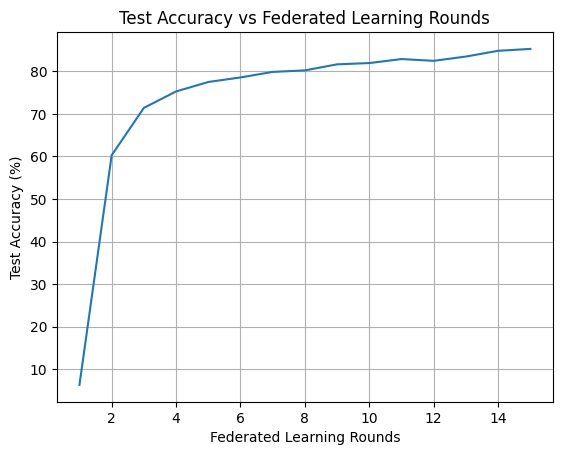

In [13]:
# 两层lora的0填充，加权聚合
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from collections import Counter
import copy
import random

torch.manual_seed(42)
random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# 定义LoRA模块，使用Xavier初始化
class LoRA(nn.Module):
    def __init__(self, input_dim, output_dim, rank):
        super(LoRA, self).__init__()
        self.rank = rank
        self.low_rank_a = nn.Parameter(torch.randn(input_dim, rank))
        self.low_rank_b = nn.Parameter(torch.randn(rank, output_dim))
        self.weight = nn.Parameter(torch.randn(input_dim, output_dim))

        # 使用Xavier初始化
        nn.init.xavier_uniform_(self.low_rank_a)
        nn.init.xavier_uniform_(self.low_rank_b)
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        return torch.matmul(x, self.weight + torch.matmul(self.low_rank_a, self.low_rank_b))


# 定义数据预处理步骤
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# 根据标签将训练集分配到不同客户端
def distribute_data_to_clients(train_dataset, num_clients=10):
    # 统计数据集原本的每个标签的数量
    original_label_counts = Counter(train_dataset.targets.tolist())
    print("Original dataset label counts:")
    for label, count in original_label_counts.items():
        print(f"Label {label}: {count} samples")

    clients = [[] for _ in range(num_clients)]

    for label in range(num_clients):
        indices = [i for i, target in enumerate(train_dataset.targets) if target == label]
        num_splits = num_clients - label
        split_indices = torch.chunk(torch.tensor(indices), num_splits)
        for i in range(num_splits):
            clients[label + i].extend(split_indices[i].tolist())

    client_subsets = [Subset(train_dataset, client_data) for client_data in clients]

    # 输出每个客户端的每个标签的数量
    for i, client_data in enumerate(client_subsets):
        client_targets = [train_dataset.targets[idx] for idx in client_data.indices]
        client_label_counts = Counter(client_targets)

        print(f"Client {i} label counts:")
        l = [0,0,0,0,0,0,0,0,0,0]
        for label, count in client_label_counts.items():
            l[label] += count
        print(l)

    return client_subsets

client_subsets = distribute_data_to_clients(train_dataset)

# 创建测试数据加载器
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


# 定义包含LoRA的改进神经网络
class SimpleNNWithLoRA(nn.Module):
    def __init__(self, rank1, rank2):
        super(SimpleNNWithLoRA, self).__init__()
        self.fc1 = LoRA(28 * 28, 200, rank1)
        self.fc2 = LoRA(200, 200, rank2)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 创建模型
def create_model(rank_1, rank_2):
    model = SimpleNNWithLoRA(rank1 = rank_1, rank2 = rank_2).to(device) 
    return model

from copy import deepcopy
from torch.nn import functional as F
from torch.autograd import Variable

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)


class EWC(object):
    def __init__(self, model, data_loader: torch.utils.data.DataLoader):

        self.model = model
        self.data_loader = data_loader

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)

        self.model.eval()
        for input, _ in self.data_loader:
            self.model.zero_grad()
            input = variable(input)
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.data_loader)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

# 训练函数
def train_with_ewc(model, data_loader, criterion, optimizer, epochs, ewc, importance):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, targets) in enumerate(data_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets) + importance * ewc.penalty(model)
            loss.backward()
            optimizer.step()

def train(model, data_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, targets) in enumerate(data_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()


# 测试函数
def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    return accuracy


def clip_tensor(tensor,new_shape):
    dim_row, dim_col = new_shape
    new_tensor = torch.zeros(new_shape, dtype=tensor.dtype)
    for i in range(dim_row):
        for j in range(dim_col):
            new_tensor[i,j] = tensor[i,j]
    return new_tensor


def resize_tensor(tensor, new_shape):
    # 获取当前张量的形状
    dim_row, dim_col = tensor.shape
    # 创建一个新的张量，形状为 (当前行数, 当前列数 + 1)，并用0填充
    new_tensor = torch.zeros(new_shape, dtype=tensor.dtype)
    # 将原始张量的内容复制到新张量中
    for i in range(dim_row):
        for j in range(dim_col):
            new_tensor[i,j] = tensor[i,j]
    return new_tensor


# 联邦加权平均函数，考虑各客户端的数据量
def federated_weighted_avg(weights, num_samples):
    avg_weights = []
    max_rank_1 = 0
    max_rank_2 = 0
    for l in weights:
        t0 = l[0]
        t1 = l[1]
        t3 = l[3]
        t4 = l[4]
        dim_1, dim_rank_1 = t0.shape
        dim_rank_1, dim_2 = t1.shape
        dim_3, dim_rank_2 = t3.shape
        dim_rank_2, dim_4 = t4.shape
        if dim_rank_1 > max_rank_1:
            max_rank_1 = dim_rank_1
        if dim_rank_2 > max_rank_2:
            max_rank_2 = dim_rank_2
    i = 0
    new_shape_0 = (dim_1, max_rank_1)
    new_shape_1 = (max_rank_1, dim_2)
    new_shape_3 = (dim_3, max_rank_2)
    new_shape_4 = (max_rank_2, dim_4)
    while i < len(weights):
        weights[i][0] = resize_tensor(weights[i][0], new_shape_0)
        weights[i][1] = resize_tensor(weights[i][1], new_shape_1)
        weights[i][3] = resize_tensor(weights[i][3], new_shape_3)
        weights[i][4] = resize_tensor(weights[i][4], new_shape_4)
        i += 1
    total_samples = sum(num_samples)
    for i in range(len(weights[0])):
        weighted_sum = sum(weights[j][i] * num_samples[j] / total_samples for j in range(len(weights)))
        avg_weights.append(weighted_sum)
    return avg_weights


# 打印权重差异
def print_weight_differences(client_weights, global_weights):
    for i, (client_weight, global_weight) in enumerate(zip(client_weights, global_weights)):
        print(f"Layer {i}:")
        print(f"  Client Weight: {client_weight.shape}")
        print(f"  Global Weight: {global_weight.shape}")
        if client_weight.shape != global_weight.shape:
            print("  Size mismatch!")
        else:
            print(f"  Max Difference: {torch.max(torch.abs(client_weight - global_weight)).item()}")


# 设置超参数
# 基准秩160（第一层），100，每个label对应0.1的系数
ranks_1 = [16,32,48,64,80,96,112,128,144,160]
ranks_2 = [10,20,30,40,50,60,70,80,90,100]
num_rounds = 15
learning_rate = 0.01
batch_size = 64
epochs_per_client = 5
importance = 5
global_models = []
global_model = create_model(rank_1 = 160, rank_2 = 100)
i = 0
while i < 10:      # 后面把这个数改成client的个数
    global_models.append(create_model(rank_1 = ranks_1[i], rank_2 = ranks_2[i]))
    i += 1
criterion = nn.CrossEntropyLoss()


# 记录每轮的准确率
accuracy_history = []

# 第一轮
client_weights = []
num_samples = []
y = 0
while y < len(client_subsets):
    client_data = client_subsets[y]
    client_loader = torch.utils.data.DataLoader(client_data, batch_size=batch_size, shuffle=True)
    model = create_model(rank_1 = ranks_1[y], rank_2 = ranks_2[y])
    #print(global_model.state_dict())
    model.load_state_dict(global_models[y].state_dict())  # 加载全局模型的权重

    ewc = EWC(model, client_loader)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    if importance is not None:
        print("with ewc")
        train_with_ewc(model, client_loader, criterion, optimizer, epochs=epochs_per_client,ewc=ewc, importance=importance)
    else:
        print("without ewc")
        train(model, client_loader, criterion, optimizer, epochs=epochs_per_client)  # 在客户端训练模型

    model_weights = [param.data.clone() for param in model.parameters()]  # 保存客户端模型的权重副本
    client_weights.append(model_weights)
    num_samples.append(len(client_data))  # 记录客户端的数据样本数量
    y += 1
# 聚合权重，使用加权平均
new_weights = federated_weighted_avg(client_weights, num_samples)
# 在测试集上评估全局模型并记录准确率
accuracy = test(global_model, test_loader)
accuracy_history.append(accuracy)
print('Round',  1, 'Test Accuracy:', accuracy * 100, '%')

# 联邦学习主循环
for round_num in range(1,num_rounds):
    client_weights = []
    num_samples = []
    y = 0
    while y < len(client_subsets):
        new_weights_client = copy.deepcopy(new_weights)

        for t in new_weights:
            print(t.shape)

        dim_r1, dim_c1 = new_weights[0].shape
        dim_r2, dim_c2 = new_weights[1].shape
        dim_r3, dim_c3 = new_weights[3].shape
        dim_r4, dim_c4 = new_weights[4].shape
        # print(dim_r1, dim_c1, dim_r2, dim_c2, ranks[y])
        new_weights_client[0] = clip_tensor(new_weights[0],(dim_r1, ranks_1[y]))
        new_weights_client[1] = clip_tensor(new_weights[1], (ranks_1[y], dim_c2))
        new_weights_client[3] = clip_tensor(new_weights[3], (dim_r3, ranks_2[y]))
        new_weights_client[4] = clip_tensor(new_weights[4], (ranks_2[y], dim_c4))
        state_dict = global_models[y].state_dict()
        new_state_dict = {key: value for key, value in zip(state_dict.keys(), new_weights_client)}
        '''
        print('看新参数')
        for t in new_weights_client:
            print(t.shape)
        '''
        global_models[y].load_state_dict(new_state_dict)

        client_data = client_subsets[y]
        client_loader = torch.utils.data.DataLoader(client_data, batch_size=batch_size, shuffle=True)
        model = create_model(rank_1 = ranks_1[y], rank_2 = ranks_2[y])
        model.load_state_dict(global_models[y].state_dict())  # 加载全局模型的权重

        ewc = EWC(model, client_loader)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        if importance is not None:
            print("with ewc")
            train_with_ewc(model, client_loader, criterion, optimizer, epochs=epochs_per_client,ewc=ewc, importance=importance)
        else:
            print("without ewc")
            train(model, client_loader, criterion, optimizer, epochs=epochs_per_client)  # 在客户端训练模型
        # train(model, client_loader, criterion, optimizer, epochs=epochs_per_client)  # 在客户端训练模型

        model_weights = [param.data.clone() for param in model.parameters()]  # 保存客户端模型的权重副本
        client_weights.append(model_weights)
        num_samples.append(len(client_data))  # 记录客户端的数据样本数量
        y += 1

    # 聚合权重，使用加权平均
    new_weights = federated_weighted_avg(client_weights, num_samples)
    # 将聚合后的新权重应用到 global_model
    state_dict = global_model.state_dict()
    new_state_dict = {key: value for key, value in zip(state_dict.keys(), new_weights)}
    global_model.load_state_dict(new_state_dict)
    # 在测试集上评估全局模型并记录准确率
    accuracy = test(global_model, test_loader)
    accuracy_history.append(accuracy)
    print('Round', round_num + 1, 'Test Accuracy:', accuracy * 100, '%')

print(importance)
# 绘制准确率关于训练轮次的折线图
x_values = list(range(1, len(accuracy_history) + 1))
y_values = [acc * 100 for acc in accuracy_history]
print(f'x_values:{x_values}')
print(f'y_values:{y_values}')
plt.plot(x_values, y_values)
plt.xlabel('Federated Learning Rounds')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs Federated Learning Rounds')
plt.grid(True)
plt.show()

# 最终全局模型的准确率
final_accuracy = test(global_model, test_loader)


# 此代码为异化秩后的
# 下周要做的事情：1.将神经网络的前两层都用Lora，初始秩为160和100，   2.可以设置一个全局随机数种子
# 3.根据tag设置每个client的rank,r=初始秩*(tag量/10)     4.share:新的聚合方法(仅把有的行平均）     5.加上ewc?
# 最后对比图的时候，可以放一个纯联邦学习，一个lora-0填充，一个lora-share,最后都加个ewc，展示的时候看看效果酌情挑选。


图像

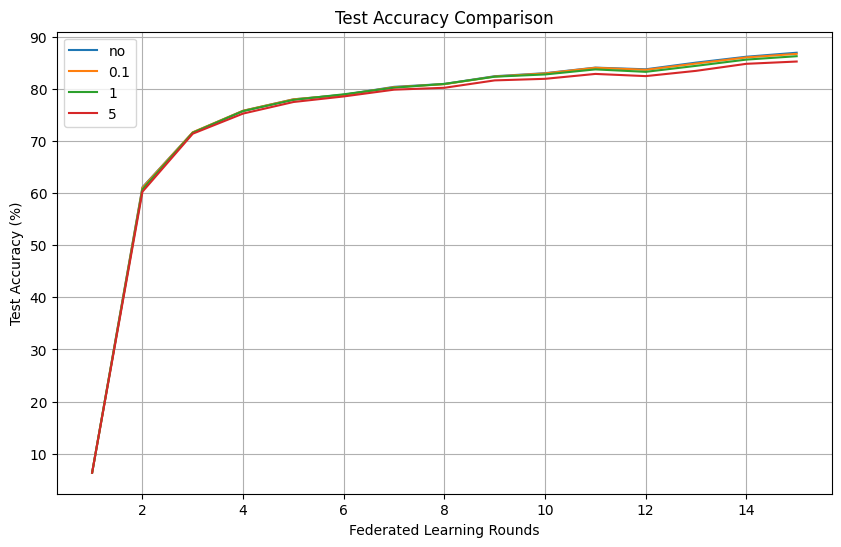

In [14]:
import matplotlib.pyplot as plt

# 定义数据
methods = ['no','0.1', '1','5']
data = {
    'no': {
        'x_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'y_values': [6.34, 61.14000000000001, 71.64, 75.81, 78.01, 78.88, 80.41, 80.96, 82.45, 83.03, 84.1, 83.78, 85.06, 86.19, 86.96000000000001]
    },
    '0.1': {
        'x_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'y_values': [6.34, 61.029999999999994, 71.69, 75.82, 78.01, 78.86, 80.34, 80.92, 82.39, 82.98, 84.07, 83.67999999999999, 84.88, 86.06, 86.74]
    },
    '1': {
        'x_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'y_values': [6.34, 60.74, 71.61, 75.76, 77.91, 78.97999999999999, 80.25, 80.97999999999999, 82.36, 82.78999999999999, 83.76, 83.28999999999999, 84.44, 85.64, 86.29]
    },
    '5': {
        'x_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'y_values': [6.34, 60.28, 71.41999999999999, 75.28, 77.5, 78.57, 79.86999999999999, 80.23, 81.65, 81.95, 82.89, 82.47, 83.48, 84.83000000000001, 85.27]
    }
}

# 绘图
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(data[method]['x_values'], data[method]['y_values'], label=method)

# 设置标签和标题
plt.xlabel('Federated Learning Rounds')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()